The notebook determines the topology and required slices of the visible portion
of the result. Since only one hemisphere of the surface is shown, a significant
portion of the data can be ignored.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
import itertools
import os
from collections import defaultdict
from enum import IntEnum

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

# For azimuth and distance calculations.
from geographiclib.geodesic import Geodesic

# To read the CMTSOLUTION file.
from obspy import read_events

In [2]:
# Some values from constants.h
R_EARTH = 6371000
R_EARTH_KM = R_EARTH / 1000
FLATTENING_F = 1.0 / 299.8e0
ONE_MINUS_F_SQUARED = (1.0 - FLATTENING_F)**2
FACTOR_TAN = 1.0 / ONE_MINUS_F_SQUARED
TINYVAL = 1.0e-9

In [3]:
# Chunk numbering and colours.
Chunk = IntEnum('Chunk', 'AB AC BC AC_ANTIPODE BC_ANTIPODE AB_ANTIPODE')

Set1 = plt.get_cmap('Set1', lut=9)
CHUNK_COLORS = [Set1(i) for i in range(9)]

In [4]:
# A close approximation to where the edge of the Orthographic projection should be.
MAX_DIST = 85

In [5]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'exact/step1-forward/DATA'

In [6]:
cmt = os.path.join(BASEDIR, 'CMTSOLUTION')
sta = os.path.join(BASEDIR, 'STATIONS_ADJOINT')
parfile = os.path.join(BASEDIR, 'Par_file')

# Load simulation information

In [7]:
# Obtain simulation parameters
config = {}
with open(parfile, 'r') as f:
    for line in f:
        line = line.split('#')[0]
        if not line:
            continue
        line = line.strip()
        if not line:
            continue

        var, value = [x.strip() for x in line.split('=', maxsplit=1)]
        config[var] = value

NCHUNKS = int(config['NCHUNKS'])
NPROC_XI = int(config['NPROC_XI'])
NPROC_ETA = int(config['NPROC_ETA'])
print("NCHUNKS = %d, NPROC_XI = %d, NPROC_ETA = %d" % (NCHUNKS, NPROC_XI, NPROC_ETA))
if NCHUNKS != 6:
    ANGULAR_WIDTH_XI_IN_DEGREES = float(config['ANGULAR_WIDTH_XI_IN_DEGREES'].replace('d', 'e'))
    ANGULAR_WIDTH_ETA_IN_DEGREES = float(config['ANGULAR_WIDTH_ETA_IN_DEGREES'].replace('d', 'e'))
    CENTER_LATITUDE_IN_DEGREES = float(config['CENTER_LATITUDE_IN_DEGREES'].replace('d', 'e'))
    CENTER_LONGITUDE_IN_DEGREES = float(config['CENTER_LONGITUDE_IN_DEGREES'].replace('d', 'e'))
    GAMMA_ROTATION_AZIMUTH = float(config['GAMMA_ROTATION_AZIMUTH'].replace('d', 'e'))
    print("xi_width = %f, eta_width = %f; clat = %f, clon = %f; grot = %f" % (
        ANGULAR_WIDTH_XI_IN_DEGREES, ANGULAR_WIDTH_ETA_IN_DEGREES,
        CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH))
else:
    ANGULAR_WIDTH_XI_IN_DEGREES = ANGULAR_WIDTH_ETA_IN_DEGREES = 90.0
    CENTER_LATITUDE_IN_DEGREES = CENTER_LONGITUDE_IN_DEGREES = GAMMA_ROTATION_AZIMUTH = None

ANGULAR_WIDTH_XI_RAD = np.deg2rad(ANGULAR_WIDTH_XI_IN_DEGREES)
ANGULAR_WIDTH_ETA_RAD = np.deg2rad(ANGULAR_WIDTH_ETA_IN_DEGREES)

NCHUNKS = 6, NPROC_XI = 8, NPROC_ETA = 8


In [8]:
# Obtain event location
origin = read_events(cmt, format='CMTSOLUTION')[0].preferred_origin()
event_lat = origin.latitude
event_lon = origin.longitude

In [9]:
# Obtain station location
data = np.genfromtxt(sta)
if data.ndim != 1:
    raise ValueError('ERROR: STATIONS_ADJOINT files "%s" should contain only one '
                     'station!' % (sta, ))
station_lat = data[2]
station_lon = data[3]

In [10]:
print("event = (%f,%f);  station = (%f,%f)" % (event_lat, event_lon, station_lat, station_lon))

event = (-16.080000,168.310000);  station = (25.096168,52.374339)


# Load addressing

In [11]:
slice_data = np.genfromtxt('exact/step1-forward/OUTPUT_FILES/addressing.txt', dtype=np.int_)
addressing = np.empty((NCHUNKS, NPROC_XI, NPROC_ETA), dtype=np.int_)
addressing[slice_data[:, 1] - 1, slice_data[:, 2], slice_data[:, 3]] = slice_data[:, 0]

# Find corners of every slice 

## 1 corner -> 4 corners

In [12]:
corner_data = np.repeat(slice_data, 4, axis=0)
corner_data[1::4, 2] += 1
corner_data[2::4, 2] += 1
corner_data[2::4, 3] += 1
corner_data[3::4, 3] += 1

In [13]:
corner_data[:10, :]

array([[0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 2, 0],
       [1, 1, 2, 1],
       [1, 1, 1, 1],
       [2, 1, 2, 0],
       [2, 1, 3, 0]])

## Convert corners to lat/lon

In [14]:
def rotmat(clat, clon, grot):
    """
    Calculate the 3x3 rotation matrix from the AB chunk
    frame to the actual frame defined by (clat,clon,grot).
    """

    # Compute colatitude and longitude
    alpha = np.deg2rad(clon)
    beta = np.pi / 2 - np.deg2rad(clat)
    gamma = np.deg2rad(grot)

    sina = np.sin(alpha)
    cosa = np.cos(alpha)
    sinb = np.sin(beta)
    cosb = np.cos(beta)
    sing = np.sin(gamma)
    cosg = np.cos(gamma)

    # define rotation matrix
    rotation_matrix = np.array([
        [cosg * cosb * cosa - sing * sina, -sing * cosb * cosa - cosg * sina, sinb * cosa],
        [cosg * cosb * sina + sing * cosa, -sing * cosb * sina + cosg * cosa, sinb * sina],
        [-cosg * sinb, sing * sinb, cosb]
    ])

    return rotation_matrix

In [15]:
# This algorithm originates in src/meshfem3D/compute_coordinates_grid.f90
# from specfem3d_globe.

islice = corner_data[:, 0]
ichunk = corner_data[:, 1]
iproc_xi = corner_data[:, 2]
iproc_eta = corner_data[:, 3]

ratio_xi = iproc_xi / NPROC_XI
x = 2 * ratio_xi - 1

ratio_eta = iproc_eta / NPROC_ETA
y = 2 * ratio_eta - 1

x = np.tan((ANGULAR_WIDTH_XI_RAD / 2) * x)
y = np.tan((ANGULAR_WIDTH_ETA_RAD / 2) * y)

xelem = np.empty(len(corner_data))
yelem = np.empty_like(xelem)
zelem = np.empty_like(xelem)

# define the mesh points on the top in the six regions of the cubed sphere
mask = ichunk == Chunk.AB
xelem[mask] = -y[mask]
yelem[mask] = x[mask]
zelem[mask] = 1

mask = ichunk == Chunk.AB_ANTIPODE
xelem[mask] = -y[mask]
yelem[mask] = -x[mask]
zelem[mask] = -1

mask = ichunk == Chunk.AC
xelem[mask] = -y[mask]
yelem[mask] = -1
zelem[mask] = x[mask]

mask = ichunk == Chunk.AC_ANTIPODE
xelem[mask] = -y[mask]
yelem[mask] = 1
zelem[mask] = -x[mask]
            
mask = ichunk == Chunk.BC
xelem[mask] = -1
yelem[mask] = y[mask]
zelem[mask] = x[mask]

mask = ichunk == Chunk.BC_ANTIPODE
xelem[mask] = 1
yelem[mask] = -y[mask]
zelem[mask] = x[mask]

if np.any(ichunk < 1) or np.any(ichunk > 6):
     raise ValueError('Incorrect chunk number in addressing.txt')

In [16]:
# rotate the chunk to the right location if we do not mesh the full Earth
if NCHUNKS != 6:
    rotation_matrix = rotmat(CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH)
    vector = np.empty((len(xelem), 3))
    vector[:, 0] = xelem
    vector[:, 1] = yelem
    vector[:, 2] = zelem
    vector = np.dot(vector, rotation_matrix.T)
    xelem = vector[:, 0]
    yelem = vector[:, 1]
    zelem = vector[:, 2]

In [17]:
thetaelem = np.arctan2(np.hypot(xelem, yelem), zelem)
phielem = np.arctan2(yelem, xelem)
phielem[phielem < 0] += 2 * np.pi
thetastore = np.arctan(FACTOR_TAN * np.cos(thetaelem) / np.maximum(TINYVAL, np.sin(thetaelem)))

latelem = 90 - np.rad2deg(thetaelem)
lonelem = np.rad2deg(phielem)

# Find slices visible in Orthographic projection

In [18]:
geod = Geodesic(R_EARTH, FLATTENING_F)
info = geod.Inverse(event_lat, event_lon, station_lat, station_lon)
central_point = geod.Direct(info['lat1'], info['lon1'], info['azi1'], info['s12'] / 2)
central_point

{'a12': 60.09592563527162,
 'azi1': -69.99954611345929,
 'azi2': -65.93967020191606,
 'lat1': -16.08,
 'lat2': 8.498480141057302,
 'lon1': 168.31,
 'lon2': 113.04781321158525,
 's12': 6660531.824638379}

In [19]:
visible_slices = set()
for i in range(len(corner_data)):
    dist = geod.Inverse(central_point['lat2'], central_point['lon2'],
                        latelem[i], lonelem[i])
    if dist['a12'] < MAX_DIST:
        visible_slices.add(corner_data[i, 0])

In [20]:
visible_slices_by_chunk = defaultdict(list)
for row in slice_data:
    chunk = Chunk(row[1])
    slice_number = row[0]
    if slice_number in visible_slices:
        visible_slices_by_chunk[chunk].append(slice_number)

In [21]:
visible_slices_by_chunk

defaultdict(<class 'list'>, {<Chunk.AB: 1>: [5, 6, 7, 12, 13, 14, 15, 20, 21, 22, 23, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63], <Chunk.BC: 3>: [143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191], <Chunk.AC_ANTIPODE: 4>: [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255], <Chunk.BC_ANTIPODE: 5>: [256, 257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 279], <Chunk.AB_ANTIPODE: 6>: [320, 321, 328, 329, 336, 337, 338, 344, 345, 346, 352, 353, 354

# Plot slices

In [22]:
def plot_slices(ax, slices_by_chunk, show_boundary=True):
    patches = []
    valid_names = []
    for item, color in zip(Chunk, CHUNK_COLORS):
        for slice_number in slices_by_chunk[item]:
            mask = corner_data[:, 0] == slice_number
            lat = latelem[mask]
            lon = lonelem[mask]
            xy = np.column_stack((lon, lat))
            patch = mpatches.Polygon(xy,
                                     facecolor=color,
                                     transform=ccrs.Geodetic())
            ax.add_patch(patch)

            # Special handling at poles:
            if np.any(lat == 90) or np.any(lat == -90):
                # Find the diagonal point:
                mask = lon % 90 != 0
                lon = lon[mask]
                lat = [np.copysign(90, lat[mask]), lat[mask]]
            elif np.ptp(lon) >= 180:
                # 0 and 360 are ambiguous...
                lon[lon == 0] = 360
            # Label the slice.
            ax.text(np.average(lon), np.average(lat), str(slice_number),
                    fontsize=8, horizontalalignment='center', verticalalignment='center',
                    transform=ccrs.Geodetic())

        if len(slices_by_chunk[item]):
            patches.append(patch)
            valid_names.append(item.name)

    ax.legend(patches, valid_names, loc='lower left')

    # Show the boundary for selecting a slice.
    if show_boundary:
        boundary_lat = np.empty(361)
        boundary_lon = np.empty(361)
        for i in range(360):
            info = geod.ArcDirect(central_point['lat2'], central_point['lon2'],
                                  i, MAX_DIST)
            boundary_lat[i] = info['lat2']
            boundary_lon[i] = info['lon2']
        info = geod.ArcDirect(central_point['lat2'], central_point['lon2'],
                              360 - 1e-6, MAX_DIST)
        boundary_lat[360] = info['lat2']
        boundary_lon[360] = info['lon2']

        ax.plot(boundary_lon, boundary_lat, c='k', lw=2, ls='--', transform=ccrs.Geodetic())

## All slices

In [23]:
all_slices_by_chunk = defaultdict(list)
for slice_number, chunk_id, nproc_xi, nproc_eta in slice_data:
    all_slices_by_chunk[Chunk(chunk_id)].append(slice_number)

In [24]:
all_slices_by_chunk

defaultdict(<class 'list'>, {<Chunk.AB: 1>: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], <Chunk.AC: 2>: [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], <Chunk.BC: 3>: [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191], <Chunk.AC_ANTIPODE: 4>: [192, 193, 194, 195, 196, 197, 198, 199, 200, 

<IPython.core.display.Javascript object>


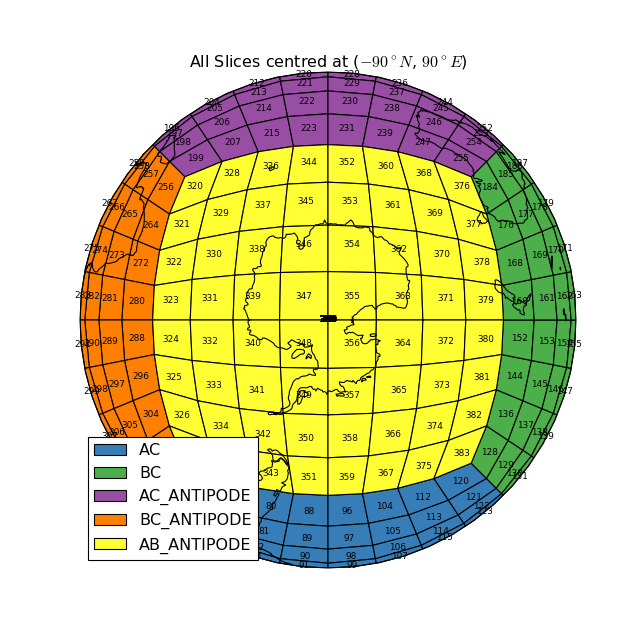

<IPython.core.display.Javascript object>


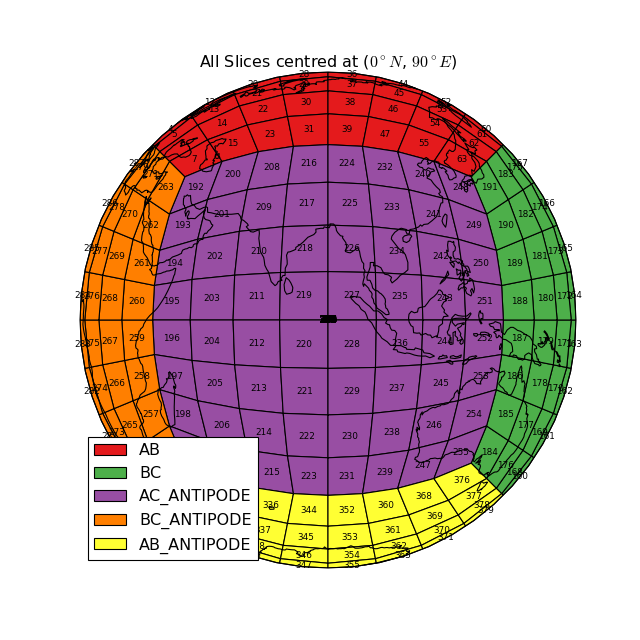

<IPython.core.display.Javascript object>


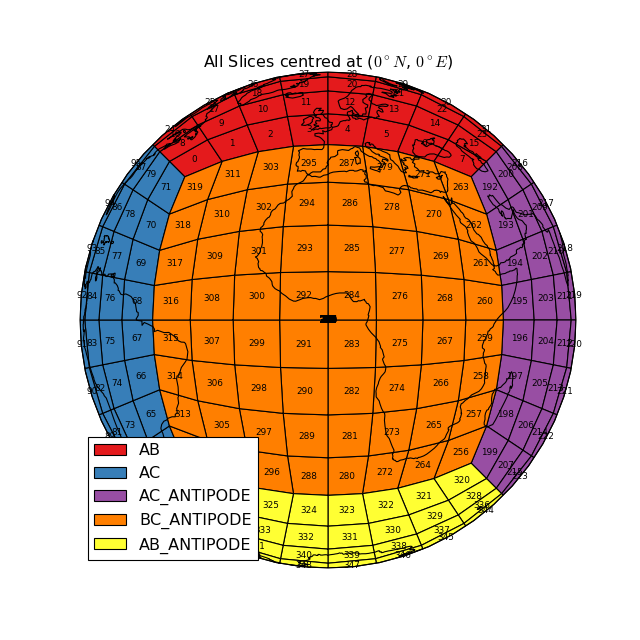

<IPython.core.display.Javascript object>


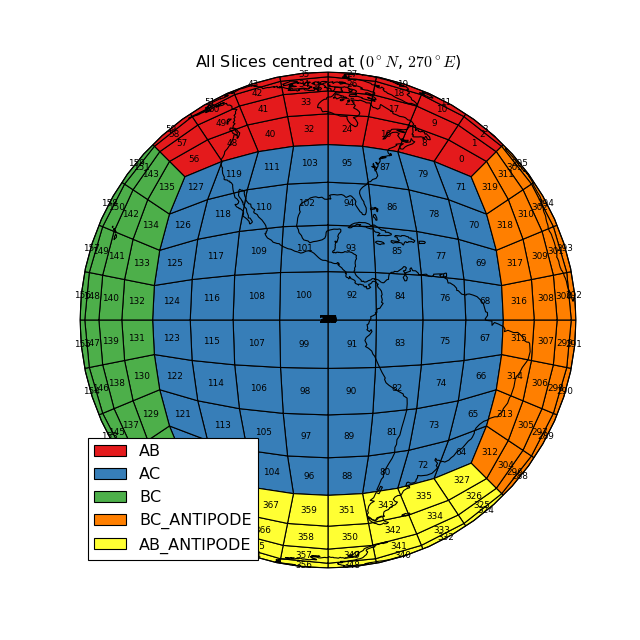

<IPython.core.display.Javascript object>


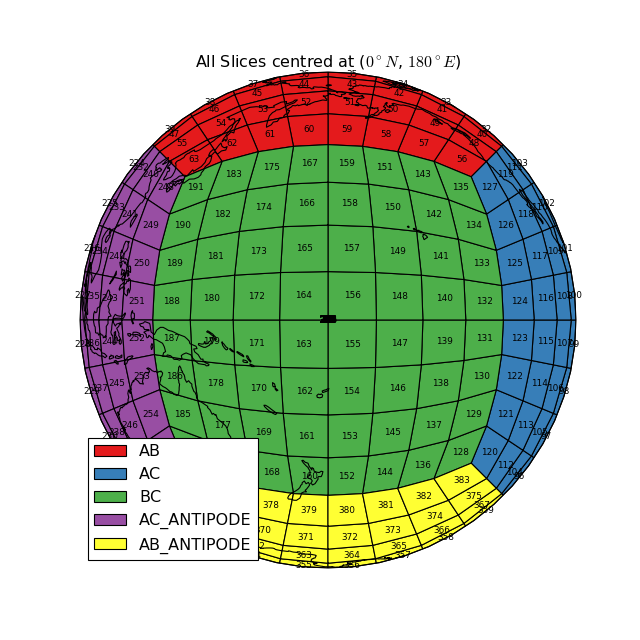

<IPython.core.display.Javascript object>


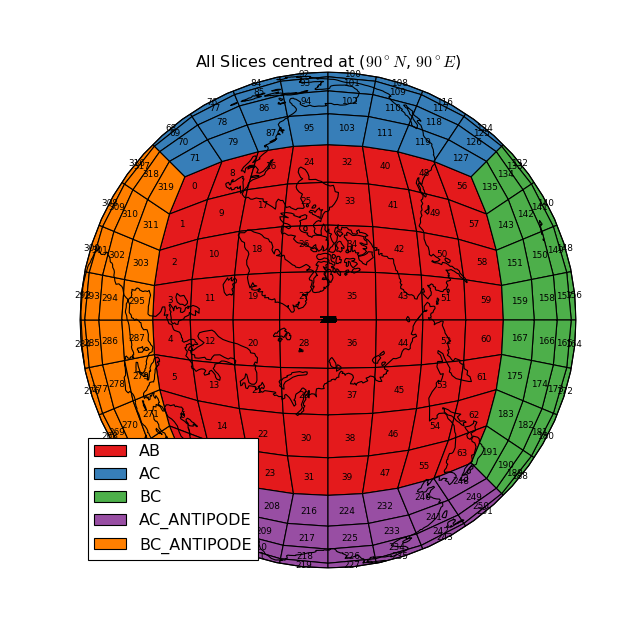

In [25]:
for hidden_chunk, (clat, clon) in zip(Chunk,
                                      [(-90, 90),
                                       (0, 90),
                                       (0, 0),
                                       (0, 270),
                                       (0, 180),
                                       (90, 90)]):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.Orthographic(central_latitude=clat, central_longitude=clon))
    ax.set_global()
    ax.coastlines()

    visible_slices = all_slices_by_chunk.copy()
    visible_slices[hidden_chunk] = []
    plot_slices(ax, visible_slices, show_boundary=False)

    ax.set_title(r'All Slices centred at ($%d^\circ N$, $%d^\circ E$)' % (clat, clon))

In [26]:
# Chunk -> [Left neighbour, top neighbour, right neighbour, bottom neighbour]
# where <loc> neighbour is (Chunk, number of CCW rotations)
# These are selected based on the plots above, but rotated so that the centre
# chunk is always top-to-bottom, left-to-right (Fortran order). This layout
# minimizes the number of rotations for each individual slice.
chunk_neighbours = {
    Chunk.AB: [
        (Chunk.BC_ANTIPODE, 1),
        (Chunk.AC, 0),
        (Chunk.BC, 3),
        (Chunk.AC_ANTIPODE, 0),
    ],

    Chunk.AC: [
        (Chunk.BC_ANTIPODE, 0),
        (Chunk.AB_ANTIPODE, 0),
        (Chunk.BC, 0),
        (Chunk.AB, 0),
    ],

    Chunk.BC: [
        (Chunk.AC, 0),
        (Chunk.AB_ANTIPODE, 3),
        (Chunk.AC_ANTIPODE, 2),
        (Chunk.AB, 1),
    ],

    Chunk.AB_ANTIPODE: [
        (Chunk.BC_ANTIPODE, 3),
        (Chunk.AC_ANTIPODE, 0),
        (Chunk.BC, 1),
        (Chunk.AC, 0),
    ],

    Chunk.AC_ANTIPODE: [
        (Chunk.BC_ANTIPODE, 2),
        (Chunk.AB, 0),
        (Chunk.BC, 2),
        (Chunk.AB_ANTIPODE, 0),
    ],

    Chunk.BC_ANTIPODE: [
        (Chunk.AC_ANTIPODE, 2),
        (Chunk.AB_ANTIPODE, 1),
        (Chunk.AC, 0),
        (Chunk.AB, 3),
    ],
}

## Selected slices only

<IPython.core.display.Javascript object>


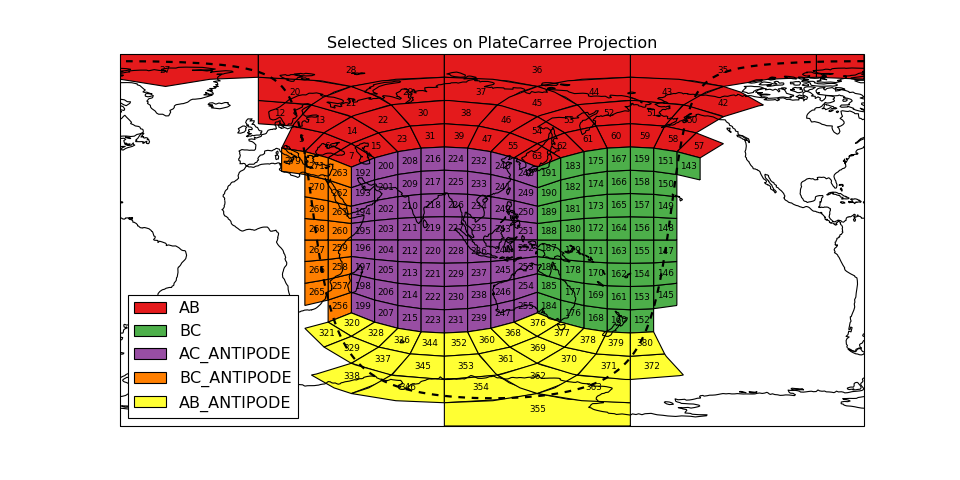

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_point['lon2']))
ax.set_global()
ax.coastlines()
plot_slices(ax, visible_slices_by_chunk)
ax.set_title('Selected Slices on PlateCarree Projection')

<IPython.core.display.Javascript object>


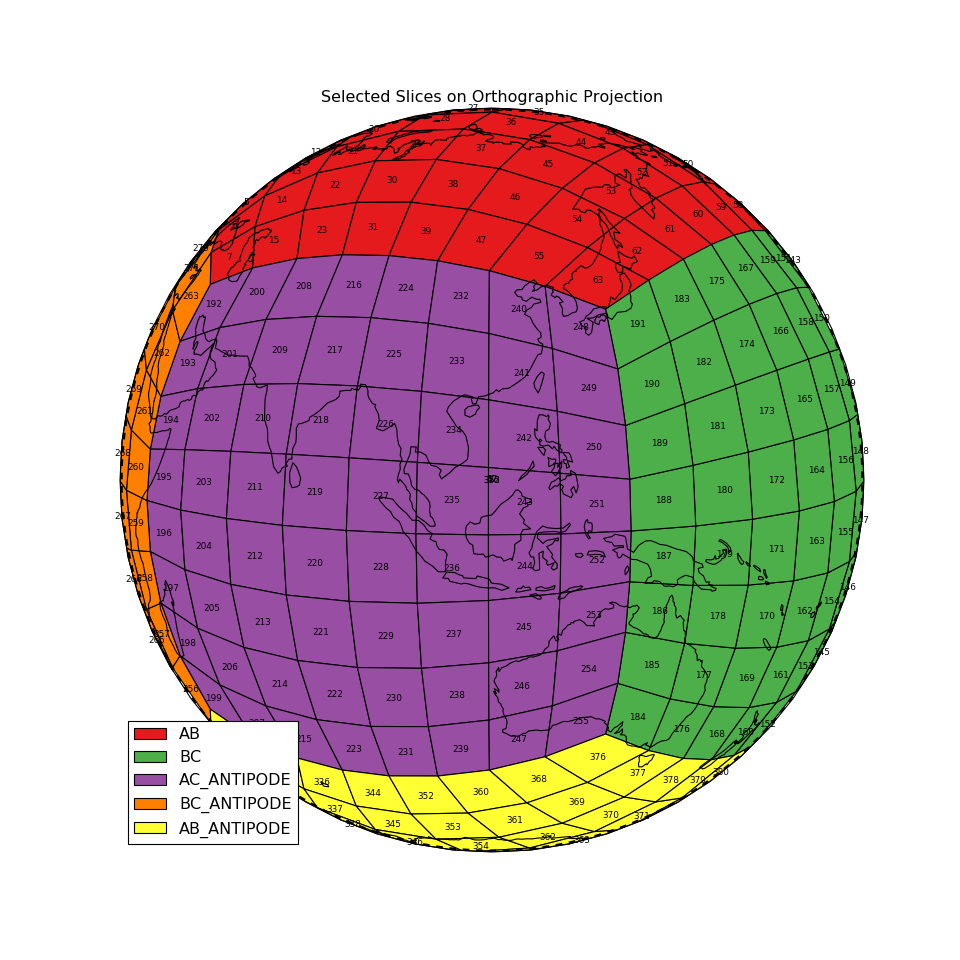

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_point['lon2'],
                                           central_latitude=central_point['lat2']))
ax.set_global()
ax.coastlines()
plot_slices(ax, visible_slices_by_chunk)
ax.set_title('Selected Slices on Orthographic Projection')

# Lay slices out in grid

In [29]:
main_chunk = max(visible_slices_by_chunk.items(), key=lambda kv: len(kv[1]))[0]

In [30]:
main_chunk

<Chunk.AC_ANTIPODE: 4>

In [31]:
left, top, right, bottom = chunk_neighbours[main_chunk]

In [32]:
chunk_start = {k: min(v) for k, v in all_slices_by_chunk.items()}
chunk_size = NPROC_XI * NPROC_ETA

chunks = []
for chunk_id, rot in [(main_chunk, 0), left, top, right, bottom]:
    chunk = -np.ones((NPROC_XI, NPROC_ETA), dtype=np.int_)
    for slice_number in visible_slices_by_chunk[chunk_id]:
        # Top-to-bottom, left-to-right
        x = (slice_number - chunk_start[chunk_id]) % NPROC_XI
        y = (slice_number - chunk_start[chunk_id]) // NPROC_XI
        chunk[x, y] = slice_number
    
    chunks.append(np.rot90(chunk, rot))

In [33]:
slice_grid = np.empty((3 * NPROC_XI, 3 * NPROC_ETA), dtype=np.int_)
slice_grid.fill(-1)
slice_rotations = np.zeros_like(slice_grid)

In [34]:
# Centre
slice_grid[NPROC_XI:2 * NPROC_XI, NPROC_ETA:2 * NPROC_ETA] = chunks[0]

# Left
slice_grid[NPROC_XI:2 * NPROC_XI, 0:NPROC_ETA] = chunks[1]
slice_rotations[NPROC_XI:2 * NPROC_XI, 0:NPROC_ETA] = left[1]

# Top
slice_grid[0:NPROC_XI, NPROC_ETA:2 * NPROC_ETA] = chunks[2]
slice_rotations[0:NPROC_XI, NPROC_ETA:2 * NPROC_ETA] = top[1]

# Right
slice_grid[NPROC_XI:2 * NPROC_XI, 2 * NPROC_ETA:3 * NPROC_ETA] = chunks[3]
slice_rotations[NPROC_XI:2 * NPROC_XI, 2 * NPROC_ETA:3 * NPROC_ETA] = right[1]

# Bottom
slice_grid[2 * NPROC_XI:3 * NPROC_XI, NPROC_ETA:2 * NPROC_ETA] = chunks[4]
slice_rotations[2 * NPROC_XI:3 * NPROC_XI, NPROC_ETA:2 * NPROC_ETA] = bottom[1]


In [35]:
# Trim grid to remove empty rows.
mask = (np.sum(slice_grid, axis=1) != -slice_grid.shape[1])
slice_grid = slice_grid[mask, :]
slice_rotations = slice_rotations[mask, :]

In [36]:
# Trim grid to remove empty columns.
mask = (np.sum(slice_grid, axis=0) != -slice_grid.shape[0])
slice_grid = slice_grid[:, mask]
slice_rotations = slice_rotations[:, mask]

In [37]:
print(slice_grid)

[[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  57  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1  42  50  58  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  27  35  43  51  59  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  12  20  28  36  44  52  60  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1   5  13  21  29  37  45  53  61  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1   6  14  22  30  38  46  54  62  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1   7  15  23  31  39  47  55  63  -1  -1  -1  -1  -1  -1  -1]
 [279 271 263 192 200 208 216 224 232 240 248 191 183 175 167 159 151 143]
 [ -1 270 262 193 201 209 217 225 233 241 249 190 182 174 166 158 150  -1]
 [ -1 269 261 194 202 210 218 226 234 242 250 189 181 173 165 157 149  -1]
 [ -1 268 260 195 203 211 219 227 235 243 251 188 180 172 164 156 148  -1]
 [ -1 267 259 196 204 212 220 228 236 244 252 187 179 171 163 155 147  -1]
 [ -1 266 258 197 205 213 221 229 237 245 253 186 178 170 162 154 146  -1]
 [ -1 265 257 198 206 214

In [38]:
print(slice_rotations)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
np.savez_compressed('slices', grid=slice_grid, rotation=slice_rotations)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.